In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [8]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '1_notMINST/' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified 1_notMINST/notMNIST_large.tar.gz
Attempting to download: notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified 1_notMINST/notMNIST_small.tar.gz


In [9]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for 1_notMINST/notMNIST_large. This may take a while. Please wait.
['1_notMINST/notMNIST_large\\A', '1_notMINST/notMNIST_large\\B', '1_notMINST/notMNIST_large\\C', '1_notMINST/notMNIST_large\\D', '1_notMINST/notMNIST_large\\E', '1_notMINST/notMNIST_large\\F', '1_notMINST/notMNIST_large\\G', '1_notMINST/notMNIST_large\\H', '1_notMINST/notMNIST_large\\I', '1_notMINST/notMNIST_large\\J']
Extracting data for 1_notMINST/notMNIST_small. This may take a while. Please wait.
['1_notMINST/notMNIST_small\\A', '1_notMINST/notMNIST_small\\B', '1_notMINST/notMNIST_small\\C', '1_notMINST/notMNIST_small\\D', '1_notMINST/notMNIST_small\\E', '1_notMINST/notMNIST_small\\F', '1_notMINST/notMNIST_small\\G', '1_notMINST/notMNIST_small\\H', '1_notMINST/notMNIST_small\\I', '1_notMINST/notMNIST_small\\J']


In [11]:
#Problem1: Display a sample of the images that we just download
nums_image_show = 2#显示的图像张数
for index_class in range(num_classes):
    #i from 0 to 9
    imagename_list = os.listdir(train_folders[index_class])
    imagename_list_indice = imagename_list[0:nums_image_show]
    for index_image in range(nums_image_show):
        path = train_folders[index_class] +'/' + imagename_list_indice[index_image]
        display(Image(filename = path))

In [12]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

1_notMINST/notMNIST_large\A.pickle already present - Skipping pickling.
1_notMINST/notMNIST_large\B.pickle already present - Skipping pickling.
1_notMINST/notMNIST_large\C.pickle already present - Skipping pickling.
1_notMINST/notMNIST_large\D.pickle already present - Skipping pickling.
1_notMINST/notMNIST_large\E.pickle already present - Skipping pickling.
1_notMINST/notMNIST_large\F.pickle already present - Skipping pickling.
1_notMINST/notMNIST_large\G.pickle already present - Skipping pickling.
1_notMINST/notMNIST_large\H.pickle already present - Skipping pickling.
1_notMINST/notMNIST_large\I.pickle already present - Skipping pickling.
1_notMINST/notMNIST_large\J.pickle already present - Skipping pickling.
1_notMINST/notMNIST_small\A.pickle already present - Skipping pickling.
1_notMINST/notMNIST_small\B.pickle already present - Skipping pickling.
1_notMINST/notMNIST_small\C.pickle already present - Skipping pickling.
1_notMINST/notMNIST_small\D.pickle already present - Skipping pi

D:\Coding\IDE\Anaconda\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


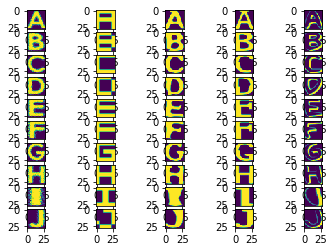

In [14]:
# Problem 2 Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. 
#Hint: you can use matplotlib.pyplot.
%matplotlib inline
import matplotlib.pyplot as plt
def load_and_displayImage_from_pickle(data_filename_set,NumClass,NumImage):
    if(NumImage <= 0):
        print("NumImage <= 0")
        return
    plt.figure('subplot')
    for index,pickle_file in enumerate(data_filename_set):
        with open(pickle_file,'rb') as f:
            data = pickle.load(f)
            ImageList = data[0:NumImage,:,:]
            for i,Image in enumerate(ImageList):
                plt.subplot(NumClass,NumImage,index*NumImage+i+1)
                plt.imshow(Image)
            index = index + 1
load_and_displayImage_from_pickle(train_datasets,10,5)
load_and_displayImage_from_pickle(test_datasets,10,5)

train_datasets:

52909
52911
52912
52911
52912
52912
52912
52912
52912
52911


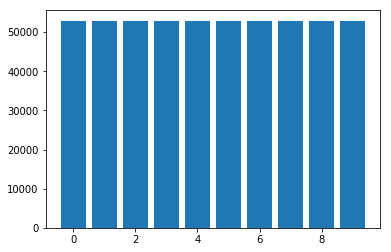

test_datasets:

1872
1873
1873
1873
1873
1872
1872
1872
1872
1872


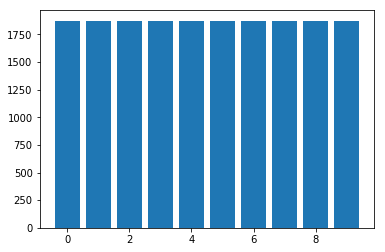

In [16]:
def show_sum_of_different_class(data_filename_set):
    plt.figure(1)
    #read .pickle file
    sumofdifferentclass = []
    for pickle_file in data_filename_set:
        with open(pickle_file,'rb') as f:
            data = pickle.load(f)
            print(len(data))
            sumofdifferentclass.append(len(data))

    #show the data
    x = range(10)
    plt.bar(x,sumofdifferentclass)    
    plt.show()

print('train_datasets:\n')    
show_sum_of_different_class(train_datasets)  
print('test_datasets:\n')    
show_sum_of_different_class(test_datasets) 

In [17]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [18]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

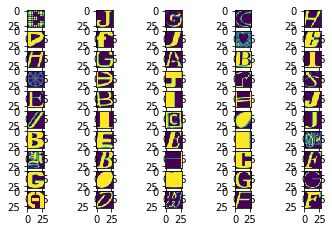

In [19]:
#Problem4 Convince yourself that the data is still good after shuffling!
#data_set是数据集，NumImage是显示的图像张数
def displayImage_from_dataset(data_set,NumImage):
    if(NumImage <= 0):
        print('NumImage <= 0')
        return
    plt.figure('subplot')
    ImageList = data_set[0:NumImage,:,:]
    for index,Image in enumerate(ImageList):
        #NumClass代表类别，每个类别一行;NumImage代表每个类显示的图像张数
        plt.subplot(NumImage//5+1, 5, index+1)
        plt.imshow(Image)
        index = index+1    
    plt.show()
displayImage_from_dataset(train_dataset,50) 

In [20]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [21]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


Number of overlaps: 1324


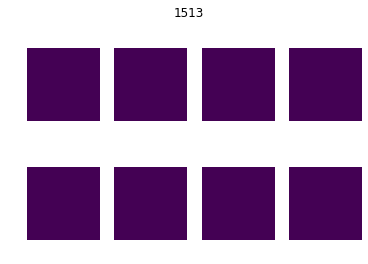

Overlapping images removed from test_dataset:  1324
Overlapping images removed from valid_dataset:  1067
Training: (200000, 28, 28) (200000,)
Validation: (8933,) (8933,)
Testing: (8676, 28, 28) (8676,)
Compressed pickle size: 690800506


In [22]:
#先使用hash
import hashlib

#使用sha的作用是将二维数据和哈希值之间进行一一对应，这样，通过比较哈希值就能将二维数组是否相等比较出来
def extract_overlap_hash_where(dataset_1,dataset_2):

    dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
    dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
    overlap = {}
    for i, hash1 in enumerate(dataset_hash_1):
        duplicates = np.where(dataset_hash_2 == hash1)
        if len(duplicates[0]):
            overlap[i] = duplicates[0]
    return overlap

#display the overlap
def display_overlap(overlap,source_dataset,target_dataset):
    overlap = {k: v for k,v in overlap.items() if len(v) >= 3}
    item = np.random.choice(list(overlap.keys()))
    imgs = np.concatenate(([source_dataset[item]],target_dataset[overlap[item][0:7]]))
    plt.suptitle(item)
    for i,img in enumerate(imgs):
        plt.subplot(2,4,i+1)
        plt.axis('off')
        plt.imshow(img)
    plt.show()

#数据清洗
def sanitize(dataset_1,dataset_2,labels_1):
    dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
    dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
    overlap = []
    for i,hash1 in enumerate(dataset_hash_1):
        duplictes = np.where(dataset_hash_2 == hash1)
        if len(duplictes[0]):
            overlap.append(i)
    return np.delete(dataset_1,overlap,0),np.delete(labels_1, overlap, None)


overlap_test_train = extract_overlap_hash_where(test_dataset,train_dataset)
print('Number of overlaps:', len(overlap_test_train.keys()))
display_overlap(overlap_test_train, test_dataset, train_dataset)

test_dataset_sanit,test_labels_sanit = sanitize(test_dataset,train_dataset,test_labels)
print('Overlapping images removed from test_dataset: ', len(test_dataset) - len(test_dataset_sanit))

valid_dataset_sanit, valid_labels_sanit = sanitize(valid_dataset, train_dataset, valid_labels)
print('Overlapping images removed from valid_dataset: ', len(valid_dataset) - len(valid_dataset_sanit))

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_labels_sanit.shape, valid_labels_sanit.shape)
print('Testing:', test_dataset_sanit.shape, test_labels_sanit.shape)

pickle_file_sanit = 'notMNIST_sanit.pickle'
try:
    f = open(pickle_file_sanit,'wb')
    save = {
        'train_dataset':train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
    }
    pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

statinfo = os.stat(pickle_file_sanit)
print('Compressed pickle size:', statinfo.st_size)


In [23]:
def train_and_predict(sample_size):
    regr = LogisticRegression()
    X_train = train_dataset[:sample_size].reshape(sample_size,784)
    y_train = train_labels[:sample_size]
    regr.fit(X_train,y_train)
    X_test = test_dataset.reshape(test_dataset.shape[0],28*28)
    y_test = test_labels

    pred_labels = regr.predict(X_test)
    print('Accuracy:', regr.score(X_test, y_test), 'when sample_size=', sample_size)

for sample_size in [50,100,1000,5000,len(train_dataset)]:
    train_and_predict(sample_size)

D:\Coding\IDE\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Coding\IDE\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\Coding\IDE\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Coding\IDE\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy: 0.509 when sample_size= 50
Accuracy: 0.6966 when sample_size= 100


D:\Coding\IDE\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Coding\IDE\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy: 0.8333 when sample_size= 1000


D:\Coding\IDE\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Coding\IDE\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy: 0.8511 when sample_size= 5000


D:\Coding\IDE\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Coding\IDE\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy: 0.8933 when sample_size= 200000


作者：jidebingfeng 
来源：CSDN 
原文：https://blog.csdn.net/jidebingfeng/article/details/78013799 
